# Binary Classification with Neural Networks

## Imports and Plot Setup

In [1]:
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from sklearn import preprocessing
from torch.nn import init
import math
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

pd.options.display.max_columns = 999
pd.options.display.max_rows = 20

## Data Preprocessing

In [20]:
import numpy as np
import pickle
from sklearn import preprocessing
from sklearn.utils import shuffle
import re

# ok        
def preprocessor_libsvm_data(filename, format_label_func=lambda _: _):
    with open('./uci/' + filename + '.data', 'r') as inputfile:
        features = []
        labels = []
        for line in inputfile:
            container = line.rstrip().split()
            label = float(container[0])
            label = int(format_label_func(label))
            del container[0]
            pattern = re.compile(r"[-+]?\d+:([-+]?\d*\.\d+|[-+]?\d+)")
            feature = []
            for phrase in container:
                # print(phrase)
                target = re.findall(pattern, phrase)
                # print(target)
                feature.append(float(target[0]))
            features.append(feature)
            labels.append(label)
        classes = list(set(labels))
        for i in range(len(labels)):
            if labels[i] == classes[0]:
                labels[i] = 1
            else:
                labels[i] = 0
        features = np.array(features)
        labels = np.array(labels).reshape((-1,1))
        labels = labels.astype(np.float)
        data = np.concatenate((features,labels),axis=1)
        return data

In [21]:
def load_data(dataset):
    data = preprocessor_libsvm_data(dataset)
    row, col = data.shape
    data = pd.DataFrame(data)
    data[[col - 1]] = data[[col - 1]].astype('int')
    return data

In [47]:
data = load_data("breast-cancer")
data

,0,1,2,3,4,5,6,7,8,9,10
0,1000025.0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,1
1,1002945.0,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0,1
2,1015425.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1
3,1016277.0,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0,1
4,1017023.0,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0,1
5,1017122.0,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1.0,0
6,1018099.0,1.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,1.0,1
7,1018561.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,1.0,1.0,1
8,1033078.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1
9,1033078.0,4.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1


## Visualization

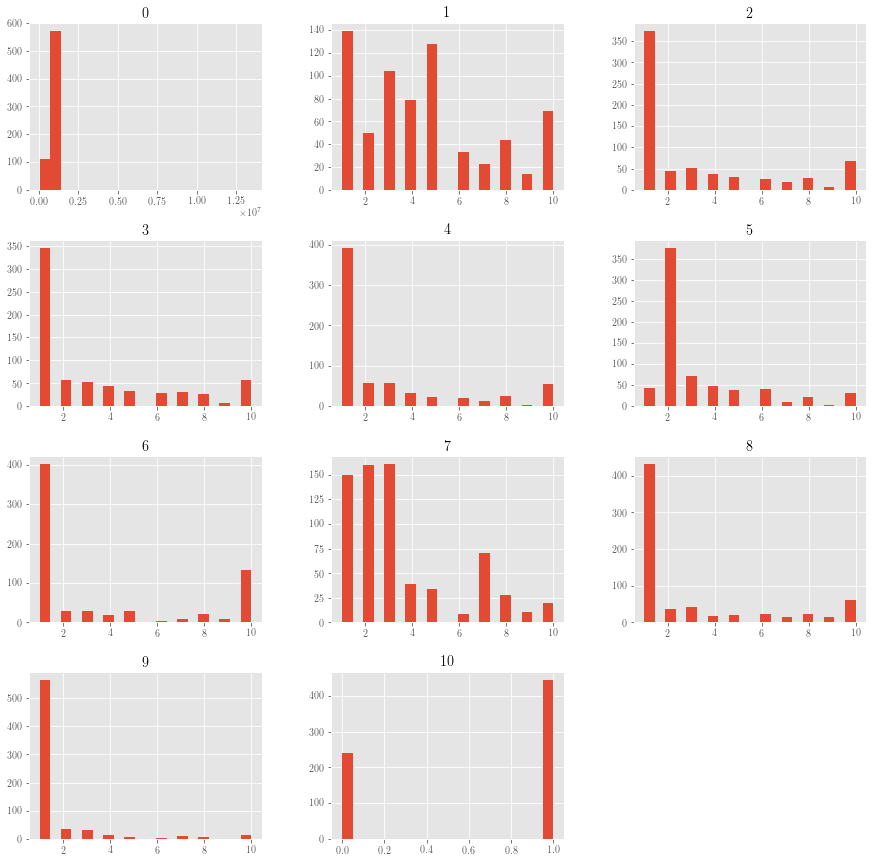

In [48]:
# Histogram of original dataframe
pd.DataFrame.hist(data=data, figsize=[15,15], bins=20);

## Data Processing

In [38]:
# randomly split data set into train and test sets
from sklearn.model_selection import train_test_split

row, col = data.shape

X_data = data.loc[:, :col - 2].values
y_data = data.loc[:, col - 1].values

# print(X_data)
# print(y_data)

HOLDOUT_SPLIT = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_data, 
                                                    y_data, 
                                                    test_size=HOLDOUT_SPLIT,
                                                    shuffle=True)

# transform to column vectors
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print(('Original data points: {}'.format(np.shape(X_data)[0])))
print(('Test split: {}%'.format(HOLDOUT_SPLIT * 100)))
print(('Training points: {}, Test points: {}'.format(np.shape(X_train)[0], 
                                                    np.shape(X_test)[0])))


# Precompute normalization of k-fold train/val sets for inputs
# Use scale by median and IQR (aka 'robust scaling')
# Leave outputs as binary

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler

import torch
from torch.autograd import Variable


K_FOLDS = 5

cv_data = [[]]*K_FOLDS
index = 0

kf = KFold(n_splits=K_FOLDS)
for train_loc, val_loc in kf.split(X_train):
    # create robust scaler for input
    scale_in = RobustScaler().fit(X_train[train_loc])
    
    # train data for each fold
    X_train_scale = scale_in.transform(X_train[train_loc])
    y_train_scale = y_train[train_loc]  # don't scale binary
    
    # validation data for each fold
    X_val_scale = scale_in.transform(X_train[val_loc])
    y_val_scale = y_train[val_loc]
    
    # store to unpack later
    cv_data[index] = (
         Variable(torch.FloatTensor(X_train_scale), requires_grad=False),
         Variable(torch.FloatTensor(X_val_scale), requires_grad=False),
         Variable(torch.FloatTensor(y_train_scale), requires_grad=False),         
         Variable(torch.FloatTensor(y_val_scale), requires_grad=False)
    )
    
    index += 1

print(('Number of folds: {}'.format(K_FOLDS)))
print(('Train points: {}'.format(np.size(train_loc))))
print(('Val points: {}'.format(np.size(val_loc))))

Original data points: 270
Test split: 20.0%
Training points: 216, Test points: 54
Number of folds: 5
Train points: 173
Val points: 43


In [39]:
# create robust scaler for input
scale_in = RobustScaler().fit(X_train)

# all of train data
X_train_scale = scale_in.transform(X_train)
y_train_scale = y_train  # don't scale binary

# all of test data
X_test_scale = scale_in.transform(X_test)
y_test_scale = y_test

# prepare for PyTorch
X_train_tor = Variable(torch.FloatTensor(X_train_scale), requires_grad=False)
X_test_tor = Variable(torch.FloatTensor(X_test_scale), requires_grad=False)
y_train_tor = Variable(torch.FloatTensor(y_train_scale), requires_grad=False)         
y_test_tor = Variable(torch.FloatTensor(y_test_scale), requires_grad=False)

print('Train points: {}'.format(np.size(y_train_scale)))
print('Test points: {}'.format(np.size(y_test_scale)))

Train points: 216
Test points: 54


##  Define Neural Network

In [40]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(torch.nn.Module):
    
    # list of hyperparameters
    INPUT_SIZE = col - 1
    OUTPUT_SIZE = 1
    L2_PEN = 1e-6
    NUM_EPOCHS = 500
    H1_SIZE = 1024
    H2_SIZE = 64
    H3_SIZE = 64
    H1_DROPOUT = 0.9
    LR = 0.1
    
    def __init__(self):
        super(Net, self).__init__()
        self.h1 = nn.Sequential(nn.Linear(Net.INPUT_SIZE, Net.H1_SIZE, bias=True),
                                nn.LeakyReLU(negative_slope=0.01),
                                nn.Dropout(p=Net.H1_DROPOUT))
        self.h2 = nn.Sequential(nn.Linear(Net.H1_SIZE, Net.H2_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.h3 = nn.Sequential(nn.Linear(Net.H2_SIZE, Net.H3_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.output = nn.Sequential(nn.Linear(Net.H3_SIZE, Net.OUTPUT_SIZE, bias=False),
                                nn.Sigmoid())
        
    def forward(self, x):
        
        out = self.h1(x)
        out = self.h2(out)
        out = self.h3(out)
        out = self.output(out)     
        
        return out

## Define ResNet Based on Net

In [41]:
class ResNet(torch.nn.Module):
    
    # list of hyperparameters
    INPUT_SIZE = col - 1
    OUTPUT_SIZE = 1
    L2_PEN = 1e-6
    NUM_EPOCHS = 500
    H1_SIZE = INPUT_SIZE
    H2_SIZE = INPUT_SIZE
    H3_SIZE = INPUT_SIZE
    H1_DROPOUT = 0.9
    LR = 0.1
    
    def __init__(self):
        super(ResNet, self).__init__()
        self.h1 = nn.Sequential(nn.Linear(ResNet.INPUT_SIZE, ResNet.H1_SIZE, bias=True),
                                nn.LeakyReLU(negative_slope=0.01),
                                nn.Dropout(p=ResNet.H1_DROPOUT))
        self.h2 = nn.Sequential(nn.Linear(ResNet.H1_SIZE, ResNet.H2_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.h3 = nn.Sequential(nn.Linear(ResNet.H2_SIZE, ResNet.H3_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.h4 = nn.Sequential(nn.Linear(ResNet.H2_SIZE, ResNet.H3_SIZE, bias=False),
                                nn.LeakyReLU(negative_slope=0.01))
        self.output = nn.Sequential(nn.Linear(ResNet.H3_SIZE, ResNet.OUTPUT_SIZE, bias=False),
                                nn.Sigmoid())
        
    def forward(self, x):
        
        out = self.h1(x) + x
        out = self.h2(out) + out
        out = self.h3(out) + out
        out = self.h4(out) + out
        out = self.output(out)     
        
        return out

### Define Accuracy for Predictions

In [42]:
def accuracy(y_pred, y_true):
    right = np.sum((y_pred.data.numpy() > 0.5) == y_true.data.numpy())
    total = y_true.data.numpy().shape[0]
    return 100. * float(right) / float(total)

## Training and Testing

In [43]:
def train_test(network):

    VERBOSE = True

    final_net = network
    final_net.train()

    # optimizer = torch.optim.Adam(net.parameters(), weight_decay=Net.L2_PEN, lr=Net.LR)
    optimizer = torch.optim.SGD(final_net.parameters(), 
                                weight_decay=Net.L2_PEN, 
                                lr=Net.LR,
                                momentum=0.0,
                                dampening=0.0,
                                nesterov=False)
    loss_func = torch.nn.BCELoss()

    epochs = np.arange(Net.NUM_EPOCHS)
    hist_loss_train = np.zeros(Net.NUM_EPOCHS)
    hist_loss_test = np.zeros(Net.NUM_EPOCHS)
    hist_correct_train = np.zeros(Net.NUM_EPOCHS)
    hist_correct_test = np.zeros(Net.NUM_EPOCHS)

    for step in range(Net.NUM_EPOCHS):
        # Show improvement on test set
        final_net.eval()
        test_pred = final_net(X_test_tor)
        loss_test = loss_func(test_pred, y_test_tor)
        hist_loss_test[step] = loss_test
        hist_correct_test[step] = accuracy(test_pred, y_test_tor)

        # Perform train cost fn
        final_net.train()
        train_pred = final_net(X_train_tor)
        loss_train = loss_func(train_pred, y_train_tor)
        hist_loss_train[step] = loss_train
        hist_correct_train[step] = accuracy(train_pred, y_train_tor)

        if VERBOSE and ((step % 100) == 0) and step != 0:
            print('Step: {}'.format(step))
            print('\tTrain Accuracy: {}%'.format(hist_correct_train[step]))
            print('\tTest Accuracy: {}%'.format(hist_correct_test[step]))

        # Update based on train performance
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

    print('\nFinal Train Accuracy: {}%'.format(hist_correct_train[-1]))
    print('Final Test Accuracy: {}%'.format(hist_correct_test[-1]))
    # print('Mean cross validation performance: {}'.format(fold_mean))
    
    plt.plot(epochs, hist_correct_train, epochs, hist_correct_test)
    # plt.title('Final Test Accuracy'.format(fold))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.show()

Net: 
Step: 100
	Train Accuracy: 78.70370370370371%
	Test Accuracy: 92.5925925925926%
Step: 200
	Train Accuracy: 82.4074074074074%
	Test Accuracy: 94.44444444444444%
Step: 300
	Train Accuracy: 81.48148148148148%
	Test Accuracy: 94.44444444444444%
Step: 400
	Train Accuracy: 86.57407407407408%
	Test Accuracy: 94.44444444444444%

Final Train Accuracy: 86.57407407407408%
Final Test Accuracy: 94.44444444444444%


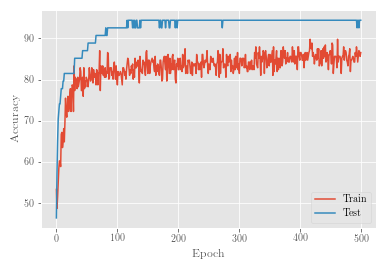


ResNet: 
Step: 100
	Train Accuracy: 80.55555555555556%
	Test Accuracy: 83.33333333333333%
Step: 200
	Train Accuracy: 84.25925925925925%
	Test Accuracy: 87.03703703703704%
Step: 300
	Train Accuracy: 87.03703703703704%
	Test Accuracy: 88.88888888888889%
Step: 400
	Train Accuracy: 88.42592592592592%
	Test Accuracy: 85.18518518518519%

Final Train Accuracy: 91.66666666666667%
Final Test Accuracy: 85.18518518518519%


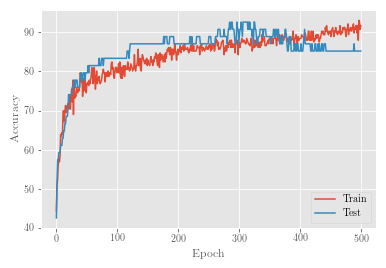

In [44]:
print('Net: ')
train_test(Net())
print('\nResNet: ')
train_test(ResNet())